In [1]:
using Gmsh
using GridapGmsh
using Gridap
using Gridap.Geometry
using Gridap.TensorValues
using Gridap.CellData
using Gridap.ReferenceFEs
using Gridap.Fields
using LinearAlgebra
using LineSearches: BackTracking

In [2]:
# -------------------- CONSTANTS AND GEOMETRY --------------------
const α = 10
const β = 1
const ls = 0.01
const η = 1e-15
const p = -0.5
const E1, v1 = 210e3, 0.33
const E2, v2 = 210e3, 0.33
const GcI1, σcI1 = 2.7, 2445.42
const GcI2, σcI2 = 2.7, 2445.42

(2.7, 2445.42)

In [3]:
λ1 = E1 * v1 / ((1 + v1) * (1 - 2 * v1))
μ1 = E1 / (2 * (1 + v1))
k1 = λ1 + μ1
GcII1 = α * GcI1
σcII1 = β * σcI1
ψ_Crit_I1 = σcI1^2 / (2 * k1)
ψ_Crit_II1 = σcII1^2 / (2 * μ1)

37.873833517200005

In [4]:
model = GmshDiscreteModel("Circular_Hexagon_notch (8).msh")
labels = get_face_labeling(model)
dimension = 2
mat_tags = get_face_tag(labels, dimension)
brick = get_tag_from_name(labels, "Base")
mortar = get_tag_from_name(labels, "Lattice")

Info    : Reading 'Circular_Hexagon_notch (8).msh'...
Info    : 520 entities
Info    : 37384 nodes
Info    : 74238 elements
Info    : Done reading 'Circular_Hexagon_notch (8).msh'


3

In [5]:
function material_tag(tag)
    if tag == brick
        E, ν, GcI, σcI = E1, v1, GcI1, σcI1
    else
        E, ν, GcI, σcI = E2, v2, GcI2, σcI2
    end
    GcII = α * GcI
    σcII = β * σcI
    λ = E * ν / ((1 + ν) * (1 - 2 * ν))
    μ = E / (2 * (1 + ν))
    k = λ + μ
    ψ_Crit_I = σcI^2 / (2 * k)
    ψ_Crit_II = σcII^2 / (2 * μ)
    return λ, μ, k, GcI, GcII, ψ_Crit_I, ψ_Crit_II, σcI, σcII
end

function mI(G, tag)
    _, _, k, _, _, _, _, σcI, _ = material_tag(tag)
    return 4 * G * k / (π * ls * σcI^2)
end

function mII(G,tag)
    _, μ, _, _, _, _, _, _, σcII = material_tag(tag)
    return 4 * G * μ / (π * ls * σcII^2)
end

mII (generic function with 1 method)

In [6]:
I2 = SymTensorValue{2,Float64}(1.0, 0.0, 1.0)
I4 = I2⊗I2
I4_sym = one(SymFourthOrderTensorValue{2,Float64})
I4_vol = 0.5 * I4
I4_dev = I4_sym - I4_vol

SymFourthOrderTensorValue{2, Float64, 9}(0.5, 0.0, -0.5, 0.0, 0.5, 0.0, -0.5, 0.0, 0.5)

In [7]:
function degDer1(ϕ,G,tag)
    mIc = mI(G, tag)
    num = (ϕ - 1) * (ϕ * (2p + 1) + 1) * mIc
    den = ((ϕ*ϕ) * (mIc * p + 1) + (ϕ * (mIc - 2) + 1))*((ϕ*ϕ) * (mIc * p + 1) + (ϕ * (mIc - 2) + 1))
    den = den + η
    return num / den
end

function degDer2(ϕ,G, tag)
    mIIc = mII(G, tag)
    num = (ϕ - 1) * (ϕ * (2p + 1) + 1) * mIIc
    den = ((ϕ*ϕ) * (mIIc * p + 1) + (ϕ * (mIIc - 2) + 1))*((ϕ*ϕ) * (mIIc * p + 1) + (ϕ * (mIIc - 2) + 1))
    den = den + η
    return num / den
end

degDer2 (generic function with 1 method)

In [8]:
function σfun(ε, ε_in, s_in,G1, G2, tag)
    λ, μ, k, _, _, _, _, _, _ = material_tag(tag)
    mIc, mIIc = mI(G1,tag), mII(G2, tag)
    εdev = I4_dev ⊙ ε
    σI = k * tr(ε) * one(ε)
    σII = 2 * μ * εdev
    αI = ((1 - s_in)^2+η) / ((1 - s_in)^2+ η + mIc * s_in * (1 + p * s_in+η))
    αII = ((1 - s_in)^2+η) / ((1 - s_in)^2+ η + mIIc * s_in * (1 + p * s_in+η))
    return αI * σI + αII * σII
end

σfun (generic function with 1 method)

In [9]:
function Eigen(ε)
    Λ, P = eigen(get_array(ε))
    Λpos = diagm(0 => max.(Λ, 0.0))
    Λneg = diagm(0 => min.(Λ, 0.0))
    return TensorValue(P * Λpos * P'), TensorValue(P * Λneg * P')
end

function ψPosTen(ε, tag)
    k = material_tag(tag)[3]
    return tr(ε) > 0.0 ? 0.5 * k * (tr(ε))^2 : 0.0
end

function ψPosShear(ε, tag)
    μ = material_tag(tag)[2]
    εdev = I4_dev ⊙ ε
    εPos, _ = Eigen(εdev)
    return μ * (εPos ⊙ εPos)
end

ψPosShear (generic function with 1 method)

In [10]:
function new_EnergyState(ψPlusPrev_in,ψhPos_in)
  ψPlus_in = ψhPos_in
  if ψPlus_in >= ψPlusPrev_in
    ψPlus_out = ψPlus_in
  else
    ψPlus_out = ψPlusPrev_in
  end
  true,ψPlus_out
end
function EnergyState(ψPlusPrev_in,ψhPos_in)
  ψPlus_out = ψhPos_in
  true,ψPlus_out
end
function project(q, model, dΩ, order)
    V = FESpace(model, ReferenceFE(lagrangian, Float64, order), conformity=:L2)
    a(u,v) = ∫(u*v)*dΩ
    b(v) = ∫(v*q)*dΩ
    op = AffineFEOperator(a, b, V, V)
    return Gridap.solve(op)
end

# -------------------- SPACES --------------------
order = 1
degree = 2*order
Ω = Triangulation(model)
dΩ = Measure(Ω, degree)

reffe_PF = ReferenceFE(lagrangian, Float64, order)
V0_PF = TestFESpace(model, reffe_PF; conformity=:H1)
U_PF = TrialFESpace(V0_PF)
sh = zero(V0_PF)

reffe_Disp = ReferenceFE(lagrangian, VectorValue{2,Float64}, order)
V0_Disp = TestFESpace(model, reffe_Disp;
  conformity=:H1,
  dirichlet_tags=["BottomEdge","TopEdge"],
  dirichlet_masks=[(true,true), (false,true)])
uh = zero(V0_Disp)

LoadTagId = get_tag_from_name(labels,"TopEdge")
Γ_Load = BoundaryTriangulation(model,tags = LoadTagId)
dΓ_Load = Measure(Γ_Load,degree)
n_Γ_Load = get_normal_vector(Γ_Load)


nls = NLSolver(
  show_trace=true,
  method=:newton,
  linesearch=BackTracking(), iterations = 10)
solver = FESolver(nls)

NonlinearFESolver()

In [11]:

function run_PF(x0,vApp,cache,GcI,GcII,ψTenPrev_in,ψShearPrev_in)
     println("Enter--->run_PF")

     # Start timer
     t0 = time()
     is_done = Ref(false)

     # Background task to print time every 60 seconds
     @async begin
         while !is_done[]
             sleep(60)
             println("Still running... elapsed time: ", round((time() - t0)/60, digits=2), " minutes")
         end
     end
     U_PF = TrialFESpace(V0_PF)
     res(s,ϕ) = ∫(
       (2/pi)*ls*∇(ϕ)⋅∇(s)
       + degDer1(s, GcI,mat_tags) * (ψTenPrev_in / GcI) * ϕ
       + degDer2(s, GcII,mat_tags) * (ψShearPrev_in / GcII) * ϕ
       + (1/pi)*(2 - 2s)/ls * ϕ
     )*dΩ
     op = FEOperator(res,U_PF,V0_PF)
     sh_out = FEFunction(U_PF,x0)
     sh_out, cache = solve!(sh_out,solver,op,cache)
     is_done[] = true  # mark the process as finished
     println("Finished run_PF. Total time: ", round((time() - t0)/60, digits=2), " minutes")
  return sh_out, get_free_dof_values(sh_out), cache
end

function  stepDisp(uh_in,sh_in,vApp,GcIV,GcIIV,tag)
    uApp1(x) = VectorValue(0.0,0.0)
    uApp2(x) = VectorValue(0.0,vApp)
    U_Disp = TrialFESpace(V0_Disp,[uApp1,uApp2])
    a_Disp(u,v) = ∫( (ε(v)⊙(σfun∘(ε(u),ε(uh_in),sh_in,GcIV,GcIIV,tag))))*dΩ
    b_Disp(v) = 0.0
    op_Disp = AffineFEOperator(a_Disp ,b_Disp ,U_Disp ,V0_Disp)
    uh_out = Gridap.solve(op_Disp)
    return  uh_out
end

function χFun1(ψhTenPos_in,ψhShearPos_in)
    χVal = (ψhTenPos_in/(ψhShearPos_in + ψhTenPos_in))^2
    return χVal
end

function χFun2(ψhTenPos_in,ψhShearPos_in)
    χVal = (ψhShearPos_in/(ψhShearPos_in + ψhTenPos_in))^2
    return χVal
end

χFun2 (generic function with 1 method)

In [12]:
# -------------------- INITIAL MATERIAL FIELDS --------------------
χValPrev1 = 0.5
χValPrev2 = 0.5

χVal1 = CellField(fill(χValPrev1, num_cells(Ω)), Ω)
χVal2 = CellField(fill(χValPrev2, num_cells(Ω)), Ω)

tags_array = get_face_tag(labels, dimension)

χ_array1 = fill(χValPrev1, num_cells(Ω))
χ_array2 = fill(χValPrev2, num_cells(Ω))

Gc_array1 = map((χ, tag) -> begin
    GcI, GcII = material_tag(tag)[4:5]
    GcII + (GcI - GcII) * χ
end, χ_array1, tags_array)

Gc_array2 = map((χ, tag) -> begin
    GcI, GcII = material_tag(tag)[4:5]
    GcI + (GcII - GcI) * χ
end, χ_array2, tags_array)

GcIV = CellField(Gc_array1, Ω)
GcIIV = CellField(Gc_array2, Ω)

function GcFunI(χVal1,tag)
    GcI, GcII = material_tag(tag)[4:5]
    Gc = GcII + (GcI - GcII)*χVal1
    return Gc
end

function GcFunII(χVal2,tag)
    GcI, GcII = material_tag(tag)[4:5]
    Gc = GcI + (GcII - GcI)*χVal2
    return Gc
end

function ψCritFun(χVal1,χVal2,tag)
    ψ_Crit_I, ψ_Crit_II = material_tag(tag)[6:7]
    ψCrit_I_in = χVal1 * ψ_Crit_I
    ψCrit_II_in = χVal2 * ψ_Crit_II
    return ψCrit_I_in,ψCrit_II_in
end

ψCrit_I_Prev = (χValPrev1)*ψ_Crit_I1
ψCrit_II_Prev = (χValPrev2)*ψ_Crit_II1

ψTenPrev = CellState(ψCrit_I_Prev,dΩ)
ψShearPrev = CellState(ψCrit_II_Prev,dΩ)

println("Done.")

x0_PF = zeros(Float64, num_free_dofs(V0_PF))
cache_1 = nothing
uh = zero(V0_Disp)
sh = zero(V0_PF)
# ============================ SIMULATION PARAMETERS ============================
vApp = 0.0
const vAppMax = 0.015
delv = 0.01/50 #1e-4
innerMax = 10
count = 0
Load = Float64[]
Displacement = Float64[]
push!(Load, 0.0)
push!(Displacement, 0.0)

while  vApp .< vAppMax
    count = count  .+ 1
    
    if vApp <= 0.006
        delv = 0.006/40
    else
        delv = 5e-6
    end
    vApp = vApp .+ delv

    println("\nEntering displacement step $count : $vApp")

    for inner = 1:innerMax
        ψhTenPrev = project(ψTenPrev ,model ,dΩ,order)
        ψhShearPrev = project(ψShearPrev ,model ,dΩ,order)        
        mass_term = sum(∫((2/(π*ls)) * sh) * dΩ)
        
        numerator = sum(∫((2/π)*ls*∇(sh)⋅∇(sh) +
                          (degDer1∘(sh, GcIV, mat_tags)) * (ψhTenPrev / GcIV) * sh +
                          (degDer2∘(sh, GcIIV, mat_tags)) * (ψhShearPrev / GcIIV) * sh -
                          (2/(π*ls)) * sh * sh) * dΩ) +
                    mass_term
        
        RelErr = abs(numerator) / abs(mass_term)
        println("Relative error = ", float(RelErr))
        sh, x0_PF, cache_1 = run_PF(x0_PF, vApp, cache_1, GcIV, GcIIV, ψTenPrev, ψShearPrev)
        uh = stepDisp(uh, sh, vApp, GcIV, GcIIV, mat_tags)

        ψhTenPos_in = ψPosTen∘(ε(uh), mat_tags)
        ψhShearPos_in = ψPosShear∘(ε(uh), mat_tags)
        
        update_state!(new_EnergyState ,ψTenPrev ,ψhTenPos_in)
        update_state!(new_EnergyState ,ψShearPrev ,ψhShearPos_in)
        
        χVal1 = χFun1∘(ψTenPrev, ψShearPrev)
        χVal2 = χFun2∘(ψTenPrev, ψShearPrev)
        
        GcIV = GcFunI(χVal1,mat_tags)
        GcIIV = GcFunII(χVal2,mat_tags)
        ψCrit_I_in,ψCrit_II_in = ψCritFun(χVal1,χVal2,mat_tags)   
        # ψTenPrev = ψCrit_I_in
        # ψShearPrev = ψCrit_II_in
        update_state!(new_EnergyState ,ψTenPrev, ψCrit_I_in)
        update_state!(new_EnergyState ,ψShearPrev, ψCrit_II_in)
       
        if RelErr < 1e-4 || isnan(RelErr)
            break
        end
    end

    # Project and extract outputs
    GcVal1 = project(GcIV, model, dΩ, order)
    GcVal2 = project(GcIIV, model, dΩ, order)
    χValC1 = project(χVal1, model, dΩ, order)
    χValC2 = project(χVal2, model, dΩ, order)
    
    Node_Force = sum(∫(n_Γ_Load ⋅ (σfun∘(ε(uh), ε(uh), sh, GcVal1, GcVal2, mat_tags))) * dΓ_Load)
    println("Force: ", Node_Force[2])

    push!(Load, Node_Force[2])
    push!(Displacement, vApp)

    if mod(count, 2) == 0
        writevtk(Ω, "Modified_BKCriteria_Shear_SingleEdgeNotchPlate$count", cellfields = [
            "uh" => uh,
            "s" => sh,
            "epsi" => ε(uh),
            "modefactorI" => χValC1,
            "modefactorII" => χValC2
        ])
    end
end


Done.

Entering displacement step 1 : 0.00015000000000000001
Relative error = NaN
Enter--->run_PF
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.881848e-18              NaN
Finished run_PF. Total time: 1.19 minutes
Force: 21.75972848594422

Entering displacement step 2 : 0.00030000000000000003
Relative error = NaN
Enter--->run_PF
Iter     f(x) inf-norm    Step 2-norm 
Still running... elapsed time: ------   --------------   --------------
2.65     0     1.442079e-04              NaN
 minutes     1     8.053328e-06     5.073485e-03

     2     2.805602e-08     1.991094e-05
     3     3.428673e-13     2.450505e-10
Still running... elapsed time: 57.87 minutes
Finished run_PF. Total time: 106.89 minutes
Force: 42.54409985744581

Entering displacement step 3 : 0.00045000000000000004
Relative error = 0.02898758667925425
Enter--->run_PF
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.344459e-05         

LoadError: InterruptException:

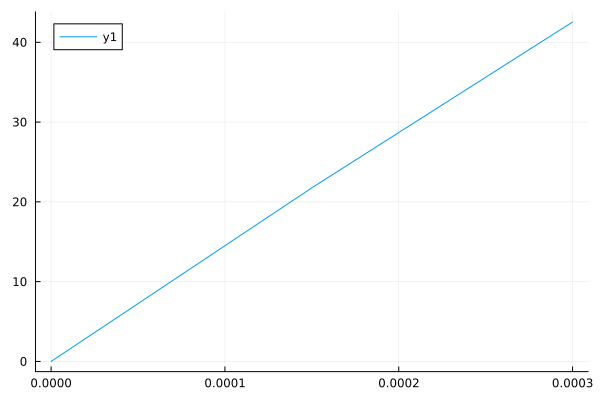

Still running... elapsed time: 19.44 minutes
Still running... elapsed time: 20.44 minutes
Still running... elapsed time: 21.44 minutes
Still running... elapsed time: 22.44 minutes


In [13]:
using Plots
plot(Displacement,Load)